In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

inspector = inspect(engine)

# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found

columns = inspector.get_columns('measurement')
print('\nmeasurement:')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
print('\nstation:')
for c in columns:
    print(c['name'], c["type"])


measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# Save references to each table

Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
import datetime
from dateutil.relativedelta import relativedelta
from datetime import datetime
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

# trip dates are August first to August seventh in a year 2018
# To get last year data for same date ranges

last_year_start_date = (datetime.strptime("2018-08-01", "%Y-%m-%d") + relativedelta(years=-1)).date()
print(last_year_start_date)

last_year_end_date = (datetime.strptime("2018-08-07", "%Y-%m-%d") + relativedelta(years=-1)).date()
print(last_year_end_date)

tmin, tavg, tmax = calc_temps(last_year_start_date,last_year_end_date)[0]
print(tmin, tavg, tmax)

2017-08-01
2017-08-07
72.0 79.25 83.0


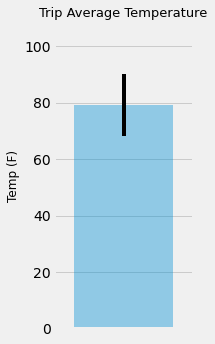

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

err = [tmax - tmin]

fig, ax = plt.subplots(figsize=(3,5))
bar = ax.bar(1,height=tavg, yerr=err, align='center', alpha=0.4, ecolor='black')

ax.set_ylabel('Temp (F)',fontsize=12)
ax.set_title('Trip Average Temperature', fontsize=13)
ax.set_xticklabels([])

ax.yaxis.grid(True)
ax.xaxis.grid(False)
ax.margins(.2,.2)
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.

select = [Station.station, Station.id, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*select).\
            filter(Station.station == Measurement.station).\
            filter(Measurement.date >= last_year_start_date).\
            filter(Measurement.date <= last_year_end_date).\
            group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(results)


[('USC00516128', 9, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36), ('USC00514830', 3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.22), ('USC00519281', 7, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06), ('USC00519397', 1, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04), ('USC00519523', 6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

print(last_year_start_date)
print(last_year_end_date)

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d

start_date = datetime.strptime(start_date, "%Y-%m-%d")
end_date = datetime.strptime(end_date, "%Y-%m-%d")

delta = end_date - start_date

date_list = []
normals = []

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    date_list.append(day.date())
    normals.append(daily_normals(f'0{day.month}-0{day.day}')[0])
    
normals

2017-08-01
2017-08-07


[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_days_rain_df = pd.DataFrame(normals,columns =['min', 'avg', 'max'])

trip_days_rain_df['date'] = date_list
trip_days_rain_df.set_index('date', inplace=True)
trip_days_rain_df

,min,avg,max
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


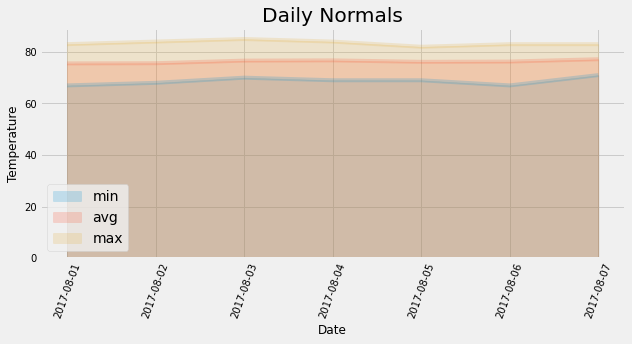

In [18]:
# Plot the daily normals as an area plot with `stacked=False`

trip_days_rain_df.plot.area(figsize=(9,5),stacked=False,alpha=0.2,title='Daily Normals',fontsize=10)
plt.xticks(rotation=70)
plt.ylabel("Temperature",fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.tight_layout()
plt.show()

## Close Session

In [17]:
session.commit()